# Recipe 2 Cuisine
## Code Challenge, Jessica Peck, October 12, 2018 

You’ve just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it’s infeasible to label them by hand. Luckily, you have a small training set of 10,000 recipes with labeled cuisines. 

### 1. Design and execute a method to predict the cuisine of a recipe given only its ingredients.

In [59]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import missingno as msno

%pylab inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth',500)    

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read in json data
with open('../recipies.json') as cuisine_intake_file:
    data = json.load(cuisine_intake_file)

In [3]:
# how much? why ~40k and not the 10k promised?
len(data)

39774

In [4]:
# what format? what does it look like?
data[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [5]:
# convert to pandas dataframe
recipedf = pd.DataFrame(data)

In [6]:
# how did that conversion go?
recipedf.head(2)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"


In [7]:
# what types are these variables?
recipedf.dtypes

cuisine        object
id              int64
ingredients    object
dtype: object

In [8]:
# yeah, but what is it really?
type(recipedf.ingredients[0])

list

In [9]:
type(recipedf.cuisine[0])

str

In [10]:
# what are the cuisines available?
recipedf.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [11]:
# are there missing cuisine labels? (nope)
sum(pd.isna(recipedf.cuisine))

0

In [12]:
# are all the ID's unique? Are there dupes? (Seems like nope.)
counts = recipedf.id.value_counts()
print(len(counts),sum(counts) )

39774 39774


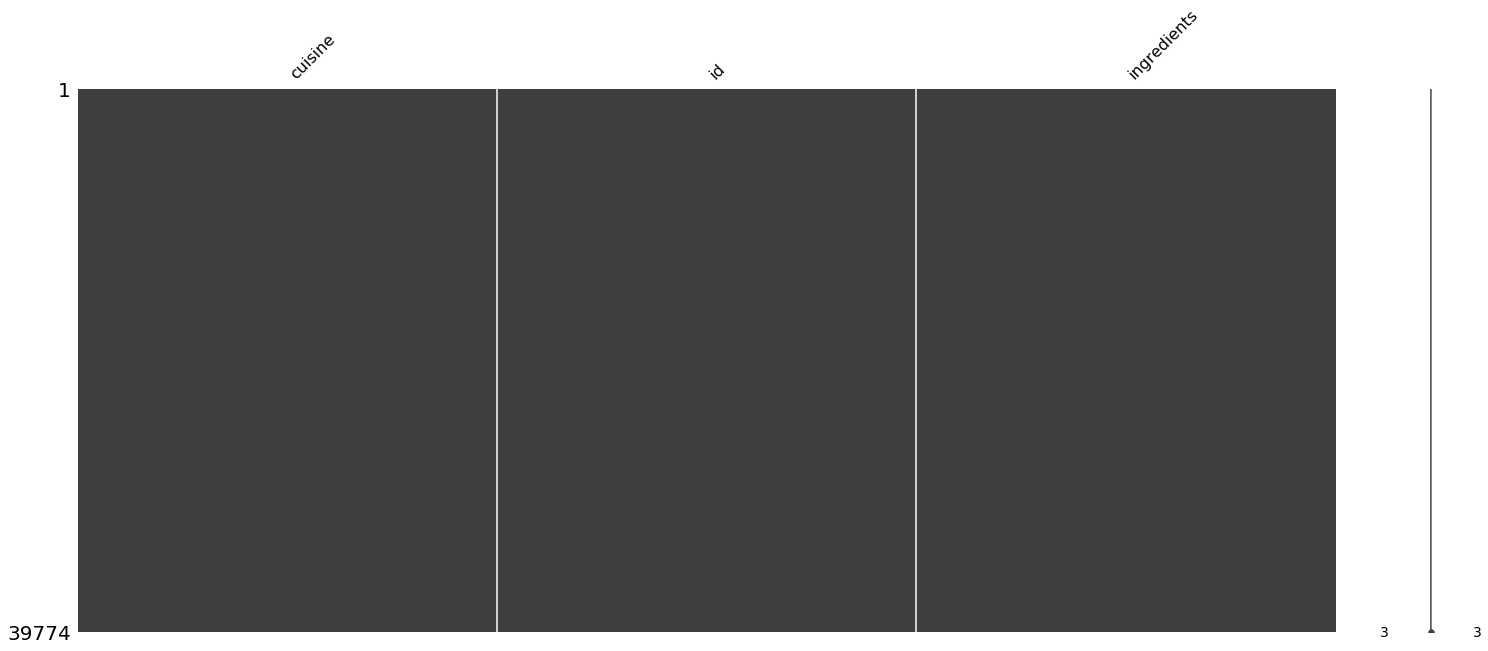

In [13]:
# Does Donald's fav shed any light on missing variables? (Nope)
msno.matrix(recipedf)

In [14]:
# How many unique features have we got?
# Is that too many for converting to dummies? (Kinda)
biglist = []
for listobject in recipedf.ingredients:
    biglist += listobject

print(len(set(biglist)), len(biglist))

6714 428275


In [15]:
# Preprocess ingredients list
# convert to space-separated strings where multi-word terms get a hyphen
# eg: [grape tomato, onion] --> [grape-tomato onion]
recipedf['text_ing'] = ['#'.join(listobject).replace(" ", "").replace("#", " ") 
                        for listobject in recipedf.ingredients]

In [16]:
# looks like this now.
recipedf.head(1)

,cuisine,id,ingredients,text_ing
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]",romainelettuce blackolives grapetomatoes garlic pepper purpleonion seasoning garbanzobeans fetacheesecrumbles


## Train Naive Bayes

In [17]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(recipedf.text_ing, recipedf.cuisine, 
                                                    test_size = .2, random_state=1)

In [18]:
# initialize model
count_vect = CountVectorizer()

In [19]:
# aim count vectorizer at text
# get sparse matrix of features
x_train_counts = count_vect.fit_transform(x_train)
x_test_counts = count_vect.transform(x_test)

In [20]:
# dimensions of feature matrix
x_train_counts.shape

(31819, 6386)

In [21]:
# fit the model
fit_model_1 = MultinomialNB().fit(x_train_counts, y_train)

In [22]:
# what is the percentage accuracy? (in sample)
fit_model_1.score(x_train_counts, y_train)

0.7712373110405732

In [23]:
# what is the percentage accuracy? (out of sample)
fit_model_1.score(x_test_counts, y_test)

0.7318667504714016

## SVM

In [24]:
# initialize model
svm_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=1, max_iter=5, tol=None)

In [25]:
# fit svm 
fit_model_2 = svm_model.fit(x_train_counts, y_train)  

In [26]:
# in sample accuracy
fit_model_2.score(x_train_counts, y_train)

0.7915710738866715

In [27]:
# out of sample accuracy
fit_model_2.score(x_test_counts, y_test)

0.7523570081709616

I'm going to recommend SVM: better accuracy, and in naive text formats the in-sample out-of-sample accuracy difference is lower (maybe better at not overfitting). 

In [28]:
# what is the shape of the coef matrix 
# for extracting cuisine names and associated ingredients
fit_model_2.coef_.shape

(20, 6386)

In [29]:
fit_model_2.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype='<U12')

In [30]:
# convert to dataframe
coef_dataframe = pd.DataFrame(fit_model_2.coef_.T, columns = fit_model_2.classes_, 
                              index = count_vect.get_feature_names())

In [31]:
# example of most impactful words/n-grams for French cuisine
coef_dataframe.french.sort_values(ascending = False).head(10)

gruyerecheese             0.866443
gratedgruyèrecheese       0.822493
cognac                    0.791100
crèmefraîche              0.621579
swisscheese               0.527400
haricotsverts             0.514843
niçoiseolives             0.508565
herbesdeprovence          0.508565
frozenpastrypuffsheets    0.496007
thymesprigs               0.489729
Name: french, dtype: float64

In [32]:
# make a dataframe of top indicator words for better printing to screen
toptens = pd.DataFrame({i: coef_dataframe[i].sort_values(ascending = False).head(10).index 
                        for i in coef_dataframe.columns})

## 3. For each major cuisine, what are the driving ingredients that characterize it.

In [33]:
toptens

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,cachaca,stiltoncheese,cajunseasoning,szechwanpeppercorns,calamansijuice,gruyerecheese,fetacheesecrumbles,garammasala,irishwhiskey,marsalawine,scotchbonnetchile,mirin,kimchi,flourtortillas,couscous,beets,grits,spanishchorizo,thairedcurrypaste,ricepaper
1,chocolatesprinkles,goldensyrup,creoleseasoning,hoisinsauce,porkbelly,gratedgruyèrecheese,fetacheese,currypowder,guinnessbeer,italianseasoning,groundallspice,sake,gochujangbase,corntortillas,raselhanout,dill,quickcookinggrits,serranoham,thaifishsauce,ricevermicelli
2,açai,suet,andouillesausage,spicepowder,lumpiawrappers,cognac,greekyogurt,ghee,cornedbeef,polenta,jamaicanjerkseason,dashi,asianpear,tequila,preservedlemon,freshdill,collardgreens,manchegocheese,redcurrypaste,vietnamesefishsauce
3,maniocflour,stilton,smokedsausage,shaoxingwine,shrimppaste,crèmefraîche,greekseasoning,groundcardamom,irishcreamliqueur,gratedparmesancheese,allspice,nori,gochugaru,salsa,harissa,farmercheese,buttermilk,chorizosausage,unsweetenedcoconutmilk,vietnamesecoriander
4,driedblackbeans,beefdrippings,celeryribs,lightsoysauce,peppercorns,swisscheese,groundlamb,plainyogurt,beefbrisket,ricottacheese,thyme,whitemiso,sesameseeds,tacoseasoning,driedapricot,sauerkraut,bourbonwhiskey,spanishpaprika,fishsauce,pickledcarrots
5,granola,raspberryjam,okra,oystersauce,hotdogs,haricotsverts,greekstyleplainyogurt,yoghurt,stout,mascarpone,driedthyme,misopaste,toastedsesameseeds,tortillachips,groundcinnamon,buckwheatflour,peaches,sherryvinegar,thaigreencurrypaste,fishsauce
6,frozenbanana,marmite,redbeans,chinesefive,cookingoil,niçoiseolives,phyllodough,basmatirice,mashedpotatoes,parmigianoreggianocheese,freshthyme,konbu,beefribshort,tomatillos,groundginger,sourcream,choppedpecans,saffronthreads,creamypeanutbutter,mungbeansprouts
7,palmoil,doublecream,celery,cornstarch,lumpiaskins,herbesdeprovence,freshdill,cuminseed,baileysirishcreamliqueur,spaghetti,groundthyme,miso,pears,masaharina,cinnamon,pickles,greentomatoes,smokedpaprika,lightcoconutmilk,staranise
8,almondmilk,spongecake,crawfish,chinesericewine,vinegar,frozenpastrypuffsheets,cucumber,groundturmeric,lambshoulder,prosciutto,rum,driedbonitoflakes,pepperflakes,tortillas,saffron,cottagecheese,eyedpeas,sherrywinevinegar,sweetchilisauce,beansprouts
9,heartsofpalm,driedcurrants,creolemustard,lowsodiumsoysauce,calamansi,thymesprigs,tahini,curryleaves,redpotato,arboriorice,nutmeg,bonitoflakes,ribeyesteaks,avocado,groundcumin,carawayseeds,black,drysherry,peanutbutter,asianfishsauce


In [34]:
toptens['french']

0             gruyerecheese
1       gratedgruyèrecheese
2                    cognac
3              crèmefraîche
4               swisscheese
5             haricotsverts
6             niçoiseolives
7          herbesdeprovence
8    frozenpastrypuffsheets
9               thymesprigs
Name: french, dtype: object

In [35]:
#count_vect.get_feature_names()

## 4. Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?

How do I make the job of disambiguating between cuisines easier for workers who have to hand label. There are some cuisines that are easily mistaken for each other based on ingredients. Can we call out those that are often mixed up? 

1. Give some defining ingredients for each.
2. Present a confusion matrix for guidance.
3. Give further defining ingredients to disambiguate between two cuisines often mistaken for each other.

In [36]:
# start with a confusion matrix
predictions = fit_model_2.predict(x_test_counts)

In [37]:
# convert to dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, predictions), 
                            columns = fit_model_2.classes_, index = fit_model_2.classes_)

In [38]:
# normalize by row sum -- not balanced classes
# italian really over-represented
row_sums = confusion_df.sum(axis = 1)
norm_df = confusion_df.div(row_sums, axis = 0)
#norm_df.sum(axis =1)

In [39]:
# here's the text of the confusion matrix / heatmap
norm_df

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,0.271605,0.000000,0.012346,0.012346,0.024691,0.024691,0.000000,0.024691,0.000000,0.160494,0.000000,0.000000,0.000000,0.222222,0.012346,0.012346,0.160494,0.000000,0.061728,0.000000
british,0.000000,0.197452,0.012739,0.006369,0.000000,0.216561,0.000000,0.057325,0.025478,0.114650,0.000000,0.006369,0.000000,0.000000,0.000000,0.019108,0.337580,0.000000,0.006369,0.000000
cajun_creole,0.000000,0.010033,0.645485,0.010033,0.000000,0.023411,0.000000,0.003344,0.003344,0.093645,0.003344,0.000000,0.000000,0.030100,0.000000,0.010033,0.163880,0.003344,0.000000,0.000000
chinese,0.001866,0.000000,0.005597,0.880597,0.003731,0.001866,0.001866,0.003731,0.001866,0.022388,0.000000,0.022388,0.005597,0.007463,0.000000,0.000000,0.007463,0.000000,0.026119,0.007463
filipino,0.006579,0.000000,0.006579,0.164474,0.467105,0.019737,0.000000,0.006579,0.013158,0.052632,0.006579,0.006579,0.019737,0.052632,0.000000,0.000000,0.072368,0.000000,0.098684,0.006579
french,0.001957,0.001957,0.007828,0.011742,0.000000,0.598826,0.000000,0.005871,0.001957,0.225049,0.001957,0.005871,0.000000,0.007828,0.009785,0.009785,0.097847,0.009785,0.001957,0.000000
greek,0.000000,0.000000,0.004255,0.004255,0.008511,0.034043,0.578723,0.017021,0.000000,0.280851,0.000000,0.004255,0.000000,0.012766,0.017021,0.000000,0.025532,0.004255,0.008511,0.000000
indian,0.000000,0.000000,0.000000,0.003328,0.000000,0.001664,0.011647,0.896839,0.001664,0.023295,0.001664,0.000000,0.000000,0.026622,0.014975,0.000000,0.011647,0.000000,0.006656,0.000000
irish,0.007246,0.036232,0.000000,0.000000,0.007246,0.123188,0.014493,0.014493,0.347826,0.057971,0.007246,0.000000,0.000000,0.036232,0.000000,0.007246,0.326087,0.014493,0.000000,0.000000
italian,0.001245,0.000000,0.004978,0.003111,0.000000,0.048538,0.008090,0.002489,0.000622,0.885501,0.001867,0.000622,0.000000,0.013690,0.000622,0.001245,0.024891,0.001867,0.000622,0.000000


If you were writing a guide, point out the cuisines that get miscategorized (each row). 
Along with the top 10 ingredients (list of terms), make sure to call out the most likely mistaken label.
Example: this is spanish food, not italian!

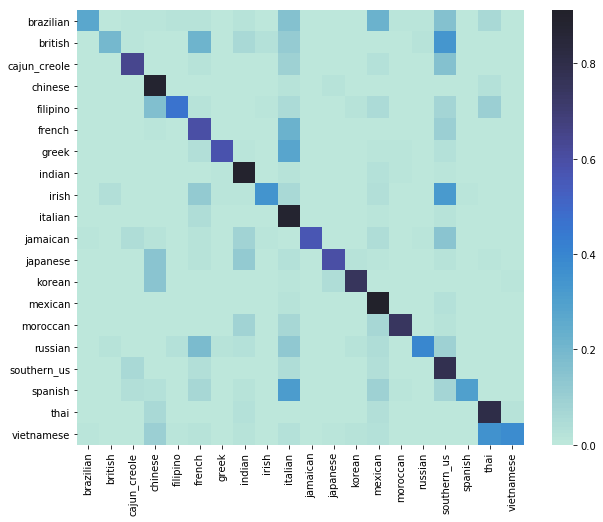

In [63]:
pyplot.figure(figsize=(10, 8))
confusion_graphic = sns.heatmap(norm_df, center = 1)


For cuisines that are commonly mixed up, I can provide a list of most-differentiable words to help guide. Subtract spanish coefficients from italian coefficients and sort ascending. Only the first few are useful and there may be overlap with the other top ten list of identifying ingredients.

In [64]:
fig = confusion_graphic.get_figure()
fig.savefig("recipe2cuisine_heatmap.png", size=3)

In [41]:
# Here are the most spanish things that maximally differentiate from italian
(coef_dataframe.spanish - coef_dataframe.italian).sort_values(ascending = False).head(5)

spanishchorizo    0.960622
saffronthreads    0.853886
sherryvinegar     0.841329
serranoham        0.778543
smokedpaprika     0.772265
dtype: float64

## Random Forest

### Random Forest with 100 trees, max depth 2

In [42]:
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)

In [43]:
fit_model_3 = random_forest_model.fit(x_train_counts, y_train)

In [44]:
fit_model_3.score(x_train_counts, y_train)

0.2759986171784154

In [45]:
fit_model_3.score(x_test_counts, y_test)

0.2818353236957888

### How about max depth 5?

In [46]:
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)

In [47]:
fit_model_4 = random_forest_model.fit(x_train_counts, y_train)

In [48]:
fit_model_4.score(x_train_counts, y_train)

0.4447028504981301

In [49]:
fit_model_4.score(x_test_counts, y_test)

0.4483972344437461

### Max depth 20, but now it's looking overfit.

In [50]:
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=1)

In [51]:
fit_model_5 = random_forest_model.fit(x_train_counts, y_train)

In [52]:
fit_model_5.score(x_train_counts, y_train)

0.5572142430623213

In [53]:
fit_model_5.score(x_test_counts, y_test)

0.5287240729101195

## 2. How could you design this to be robust enough to understand similarities/substitutions between ingredients?

I would use PCA or a similar type of dimensionality reduction. If you cut down the number of dimensions, similar features will be forced into the same feature. That’s sort of like understanding substitution of ingredients without resorting to word embeddings and actual language models.
